# Training Model

In [ ]:
pip install sentence-transformers

In [ ]:
import csv
import pandas as pd
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sentence_transformers import SentenceTransformer

## Defining some useful global variables

Next you will define some global variables that will be used throughout the assignment.

- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.


- `MAXLEN`: Maximum length of all sequences. Defaults to 16.


- `TRUNCATING`: Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to \"\\<OOV>\".
    
    
- `MAX_EXAMPLES`: Max number of examples to use. Defaults to 160000 (10% of the original number of examples)
    
    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.9
    
    
**For now leave them unchanged but after submitting your assignment for grading you are encouraged to come back here and play with these parameters to see the impact they have in the classification process.**

In [ ]:
EMBEDDING_DIM = 50
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 1960
TRAINING_SPLIT = 0.9

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone Project/Colab Notebook/all_new_label_edit_filtered.csv')
df

,Unnamed: 0,pertanyaan,jawaban,label
0,0,Apa artinya memiliki penyakit atau gangguan me...,Penyakit mental adalah kondisi kesehatan yang ...,definisi
1,1,Siapa saja yang dapat terkena penyakit atau ga...,Berdasarkan Sistem Registrasi Sampel yang dila...,definisi
2,2,Apa yang menyebabkan terjadinya penyakit atau ...,Penyebab gangguan mental belum diketahui secar...,definisi
3,3,Apa saja gejala-gejala penanda penyakit mental?,Gejala gangguan kesehatan mental sangat bervar...,definisi
4,4,Apakah penderita gangguan mental bisa sembuh?,Penderita gangguan mental tentu saja bisa semb...,definisi
...,...,...,...,...
1955,2264,"Setelah pertama kali bertemu klien, apa proses...",Mungkin tidak ada dua terapis yang sama karena...,konseling_fundamental
1956,2265,"Setelah pertama kali bertemu klien, apa proses...",Setiap konselor mungkin memiliki proses yang b...,konseling_fundamental
1957,2266,"Setelah pertama kali bertemu klien, apa proses...","Setelah bertemu dengan klien, banyak konselor ...",konseling_fundamental
1958,2267,"Setelah pertama kali bertemu klien, apa proses...",Seorang terapis yang baik akan membahas apa ya...,konseling_fundamental


In [ ]:
df['label'].value_counts()

2     359
7     334
5     328
6     249
8     240
4      83
15     66
0      58
12     51
1      50
11     40
9      38
14     23
3      22
10     10
13      9
Name: label, dtype: int64

In [ ]:
df['label'].value_counts()

depresi                   359
keluarga                  334
hubungan                  328
kecemasan                 249
konseling_fundamental     240
harga_diri                 83
trauma                     66
cari_bantuan               58
perubahan_perilaku         51
definisi                   50
penyalahgunaan_zat         40
manajemen_emosi            38
tips_pengobatan            23
diagnosis_dini             22
peningkatan_pola_tidur     10
profesional_yang_benar      9
Name: label, dtype: int64

In [ ]:
df["label"] = df["label"].astype('category')
df.dtypes

Unnamed: 0       int64
pertanyaan      object
jawaban         object
label         category
dtype: object

In [ ]:
df["label"] = df["label"].cat.codes
df.head()

,Unnamed: 0,pertanyaan,jawaban,label
0,0,Apa artinya memiliki penyakit atau gangguan me...,Penyakit mental adalah kondisi kesehatan yang ...,1
1,1,Siapa saja yang dapat terkena penyakit atau ga...,Berdasarkan Sistem Registrasi Sampel yang dila...,1
2,2,Apa yang menyebabkan terjadinya penyakit atau ...,Penyebab gangguan mental belum diketahui secar...,1
3,3,Apa saja gejala-gejala penanda penyakit mental?,Gejala gangguan kesehatan mental sangat bervar...,1
4,4,Apakah penderita gangguan mental bisa sembuh?,Penderita gangguan mental tentu saja bisa semb...,1


In [ ]:
df[df['label']==0]

,Unnamed: 0,pertanyaan,jawaban,label
5,5,Apa yang harus saya lakukan jika saya mengenal...,Kami menyarankan mereka yang memiliki gejala b...,0
8,8,"Jika saya terlibat dalam perawatan, apa yang p...",Karena memulai perawatan adalah langkah besar ...,0
10,10,Bagaimana saya dapat menemukan tenaga profesio...,Kenyamanan dengan tenaga profesional yang beke...,0
11,11,"Jika saya terlibat dalam perawatan, apa yang p...",Karena memulai perawatan adalah langkah besar ...,0
12,12,Di mana lagi saya bisa mendapatkan pertolongan?,Ke mana Anda mencari bantuan akan bergantung p...,0
15,15,Bagaimana saya bisa mendapatkan bantuan untuk ...,Beberapa perusahaan farmasi menawarkan program...,0
16,16,Ke mana saya bisa pergi untuk mencari terapi?,Berbagai jenis terapi lebih efektif berdasarka...,0
19,19,Di mana saya dapat mencari kelompok pendukung?,Banyak orang menganggap dukungan sebaya sebaga...,0
20,20,Ke mana saya bisa mencari perawatan rawat inap?,Jika Anda atau seseorang yang Anda kenal berad...,0
21,21,Di mana saya dapat mencari layanan lokal lainnya?,Kemungkinan ada banyak sumber daya yang dapat ...,0


In [ ]:
len(df[df['label']==1])

50

In [ ]:
# Test your function
sentences, labels = df['pertanyaan'], df['label']

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1960 examples

Text of second example should look like this:
Siapa saja yang dapat terkena penyakit atau gangguan mental?

Text of fourth example should look like this:
Apa saja gejala-gejala penanda penyakit mental?

Labels of last 5 examples should look like this:
1955    8
1956    8
1957    8
1958    8
1959    8
Name: label, dtype: int8


In [ ]:
print(sentences[3])
print(labels[3])

Saya terlibat dengan sahabat saya yang sudah menikah tetapi sangat tidak bahagia selama lima tahun terakhir. Kami berdua jatuh cinta dan telah bersama selama delapan bulan. Dia meninggalkan rumah dan mengajukan perceraian. Dia memutuskan untuk memberitahunya tentang hubungan kita, dan dia bersedia memaafkan dan mengerjakan sesuatu. Ini mengguncangnya. Mereka memiliki dua anak bersama. Dia memutuskan untuk menunda perceraian. Dia meninggalkan kota selama sebulan untuk mendapatkan kejelasan tentang situasi dan menemui terapis.
5


In [ ]:
# Bundle the two lists into a single one
sentences_and_labels = list(zip(sentences, labels))

# Perform random sampling
random.seed(42)
sentences_and_labels = random.sample(sentences_and_labels, MAX_EXAMPLES)

# Unpack back into separate lists
sentences, labels = zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 1960 sentences and 1960 labels after random sampling



## Training - Validation Split

Now you will code the `train_val_split`, which given the list of sentences, the list of labels and the proportion of data for the training set, should return the training and validation sentences and labels:

In [ ]:
def train_val_split(sentences, labels, training_split):
    
    ### START CODE HERE
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1764 sentences for training.

There are 1764 labels for training.

There are 196 sentences for validation.

There are 196 labels for validation.


## Tokenization - Sequences, truncating and padding

Now that you have sets for training and validation it is time for you to begin the tokenization process.

Begin by completing the `fit_tokenizer` function below. This function should return a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) that has been fitted to the training sentences.

In [ ]:
def fit_tokenizer(train_sentences, oov_token):
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words = len(train_sentences), oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [ ]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'depresi' should be {word_index['depresi']}")

Vocabulary contains 2925 words

<OOV> token included in vocabulary

index of word 'depresi' should be 56


In [ ]:
def seq_pad_and_trunc(sentences, tokenizer, padding,truncating, maxlen):
    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    
    ### END CODE HERE
    
    return pad_trunc_sequences

In [ ]:
# Test your function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (1764, 16)

Padded and truncated validation sequences have shape: (196, 16)


Remember that the `pad_sequences` function returns numpy arrays, so your training and validation sequences are already in this format.

However the labels are still Python lists. Before going forward you should convert them numpy arrays as well. You can do this by running the following cell:

In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Using pre-defined Embeddings

This time you will not be learning embeddings from your data but you will be using pre-trained word vectors.

In particular you will be using the 100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [ ]:
# Define path to file containing the embeddings
GLOVE_FILE = '/content/drive/MyDrive/Capstone Project/Colab Notebook/glove_50dim_wiki.id.case.text.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

Now you have access to GloVe's pre-trained word vectors. Isn't that cool?

Let's take a look at the vector for the word **dog**:

In [ ]:
test_word = 'mental'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word mental looks like this:

[ 0.965566 -0.456986  0.046222  0.079433 -0.490597 -0.139792  0.341623
  0.483774  0.148246 -0.521837  0.454522 -0.012234 -0.285455  0.408856
  0.158583 -0.077709 -0.128624  0.665159 -0.569225  1.070127  0.012585
 -0.375122  0.650717  1.095729  0.202949  1.791476 -0.036519  0.190781
 -0.074696  0.290087 -0.168029 -0.204264 -0.329673  0.329641 -0.028233
 -0.245577  1.399231 -1.360992 -1.634121  0.284112 -0.163756 -0.716869
 -0.885133  0.572532 -0.489868 -0.326836 -0.046332  0.447391  0.754435
  0.976553]


In [ ]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (50,)


## Represent the words in your vocabulary using the embeddings

Save the vector representation of each word in the vocabulary in a numpy array.

A couple of things to notice:
- If a word in your vocabulary is not present in `GLOVE_EMBEDDINGS` the representation for that word is left as a column of zeros.
- `word_index` starts counting at 1, because of this you will need to add an extra column at the left-most side of the `EMBEDDINGS_MATRIX` array. This is the reason why you add 1 to `VOCAB_SIZE` in the cell below:

In [ ]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

## Define a model that does not overfit

Now you need to define a model that will handle the problem at hand while not overfitting.

A couple of things to note / hints:

- The first layer is provided so you can see how the Embedding layer is configured when using pre-trained embeddings


- You can try different combinations of layers covered in previous ungraded labs such as:
    - `Conv1D`
    - `Dropout`
    - `GlobalMaxPooling1D`    
    - `MaxPooling1D`    
    - `LSTM`    
    - `Bidirectional(LSTM)`


- The last two layers should be `Dense` layers.


- There multiple ways of solving this problem. So try an architecture that you think will not overfit.


- Try simpler architectures first to avoid long training times. Architectures that are able to solve this problem usually have around 3-4 layers (excluding the last two `Dense` ones)


- Include at least one `Dropout` layer to mitigate overfitting.

In [ ]:
# GRADED FUNCTION: create_model
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    
    ### START CODE HERE
    lstm_dim = 32
    dense_dim = 24
    
    model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(lstm_dim, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.MaxPooling1D(pool_size=3),
        # tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [ ]:
# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=120, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/120
56/56 [==============================] - 2s 10ms/step - loss: 2.3070 - accuracy: 0.1950 - val_loss: 2.1010 - val_accuracy: 0.2653
Epoch 2/120
56/56 [==============================] - 0s 7ms/step - loss: 2.0387 - accuracy: 0.2885 - val_loss: 1.9411 - val_accuracy: 0.3776
Epoch 3/120
56/56 [==============================] - 0s 7ms/step - loss: 1.9003 - accuracy: 0.3526 - val_loss: 1.7863 - val_accuracy: 0.4184
Epoch 4/120
56/56 [==============================] - 0s 7ms/step - loss: 1.8159 - accuracy: 0.3821 - val_loss: 1.7644 - val_accuracy: 0.3929
Epoch 5/120
56/56 [==============================] - 0s 7ms/step - loss: 1.7357 - accuracy: 0.3844 - val_loss: 1.6428 - val_accuracy: 0.4337
Epoch 6/120
56/56 [==============================] - 0s 7ms/step - loss: 1.6650 - accuracy: 0.4110 - val_loss: 1.5434 - val_accuracy: 0.4796
Epoch 7/120
56/56 [==============================] - 0s 7ms/step - loss: 1.6210 - accuracy: 0.4337 - val_loss: 1.5686 - val_accuracy: 0.4745
Epoch 8/120


# Testing

In [ ]:
print(sentences[350])
print(labels[350])
print(sentences[100])
print(labels[100])

Terkadang saya tidak bisa berhenti memikirkan kehidupan setelah kematian. Saya dibesarkan dalam agama yang mengajarkan bahwa kita akan hidup selamanya baik di neraka atau di surga. Ketika saya berpikir untuk hidup selamanya (bahkan jika itu di surga yang seharusnya baik), saya merasa kewalahan. Saya tidak suka pikiran hidup selamanya dan selamanya. Terkadang saya tidak bisa mendapatkan pemikiran dari pikiran saya dan pikiran -pikiran itu menyebabkan kepanikan dan kecemasan. Apakah saya gila? Saya tidak berpikir pikiran ini normal.
6
Saya baru menikah tiga bulan. Setiap minggu, kami berdebat tentang sesuatu, dan tampaknya semakin buruk.
7


In [ ]:
testtext = ["saya mengalami depresi terhadap pekerjaan saya",
            "Saya sering merasa cemas terhadap masa depan",
            "saya memiliki masalah dengan keluarga saya",
            "saya memiliki hubungan buruk dengan teman saya"]

tes_pad_trunc_seq = seq_pad_and_trunc(testtext, tokenizer, PADDING, TRUNCATING, MAXLEN)

In [ ]:
res = model.predict(tes_pad_trunc_seq)

In [ ]:
for i in range(len(res)):
  print(np.argmax(res[i]))

2
6
15
5


# Save & Load

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project/Colab Notebook/models/classification_v1.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone Project/Colab Notebook/models/classification_v1.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 16, 50)            146300    
                                                                 
 dropout_5 (Dropout)         (None, 16, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                10624     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               4224      
                                                                 
 dense_13 (Dense)            (None, 16)                2064      
                                                                 
Total params: 163,212
Trainable params: 16,912
Non-tra

In [ ]:
testtext = ["saya mengalami depresi terhadap pekerjaan saya",
            "Saya sering merasa cemas terhadap masa depan",
            "saya memiliki masalah dengan keluarga saya",
            "saya memiliki hubungan buruk dengan teman saya",
            "apa yang dimaksud kesehatan mental"]

tes_pad_trunc_seq = seq_pad_and_trunc(testtext, tokenizer, PADDING, TRUNCATING, MAXLEN)

In [ ]:
res = new_model.predict(tes_pad_trunc_seq)

In [ ]:
for i in range(len(res)):
  print(np.argmax(res[i]))

2
6
15
5
1


# Cosine

In [ ]:
pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
input = "apa gejala penyakit mental? "
data = df[df['label']==1]['pertanyaan'].to_list()

In [ ]:
resp = df[df['label']==1]['jawaban'].to_list()

In [ ]:
data

In [ ]:
data_embeddings = model.encode(data)

In [ ]:
input_embeddings = model.encode(input)

In [ ]:
hasil = cosine_similarity(
    [input_embeddings],
    data_embeddings
)

In [ ]:
hasil

array([[0.8904754 , 0.8716904 , 0.8571826 , 0.9672184 , 0.87876374,
        0.93518215, 0.8626349 , 0.7452127 , 0.74010074, 0.92119265,
        0.7214229 , 0.7514156 , 0.7860793 , 0.6424922 , 0.71683514,
        0.4303501 , 0.72168624, 0.69421124, 0.76392806, 0.7922747 ,
        0.75457484, 0.75359136, 0.84478843, 0.68115556, 0.67144144,
        0.7223133 , 0.7945845 , 0.74297774, 0.68302417, 0.6734059 ,
        0.6488663 , 0.68873155, 0.7228705 , 0.7119574 , 0.68805134,
        0.7207666 , 0.80100876, 0.6834984 , 0.71961904, 0.65345806,
        0.732037  , 0.70691377, 0.66423297, 0.7063575 , 0.6825767 ,
        0.7235419 , 0.7103671 , 0.7154894 , 0.7636741 , 0.7245393 ]],
      dtype=float32)

In [ ]:
print(np.argmax(hasil))

3


In [ ]:
data[3]

'Apa saja gejala-gejala penanda penyakit mental?'

In [ ]:
resp[3]

'Gejala gangguan kesehatan mental sangat bervariasi tergantung pada jenis dan tingkat keparahan kondisinya. Berikut ini adalah daftar gejala umum yang mungkin menunjukkan gangguan kesehatan mental, terutama ketika beberapa gejala diekspresikan sekaligus.\nPada orang dewasa:\nPikiran bingung\nKesedihan atau lekas marah yang bertahan lama\nSuasana tertinggi dan terendah yang ekstrem\nKetakutan, kekhawatiran, atau kecemasan yang berlebihan\nPenarikan sosial\nPerubahan dramatis dalam kebiasaan makan atau tidur\nPerasaan marah yang kuat\nDelusi atau halusinasi (melihat atau mendengar hal-hal yang sebenarnya tidak ada)\nMeningkatkan ketidakmampuan untuk mengatasi masalah dan aktivitas sehari-hari\nPikiran untuk bunuh diri\nPenolakan masalah yang jelas\nBanyak masalah fisik yang tidak dapat dijelaskan\nPenyalahgunaan obat-obatan dan/atau alkohol\n\nPada anak yang lebih besar dan pra-remaja:\nPenyalahgunaan obat-obatan dan/atau alkohol\nKetidakmampuan untuk mengatasi masalah dan aktivitas seha

In [ ]:
def get_predict(input_text):
  

Run the following cell to check your loss curves:

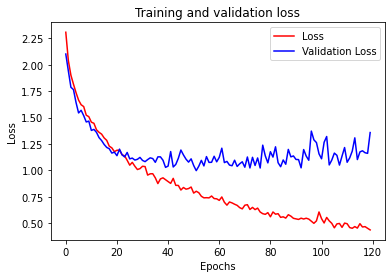

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(10)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

If you wish so, you can also check the training and validation accuracies of your model:

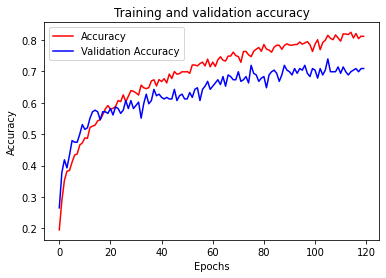

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

A more rigorous way of setting the passing threshold of this assignment is to use the slope of your `val_loss` curve.

**To pass this assignment the slope of your `val_loss` curve should be 0.0005 at maximum.**

In [ ]:
# Test the slope of your val_loss curve
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00216


**If your model generated a validation loss curve that meets the criteria above, run the following cell and then submit your assignment for grading. Otherwise, try with a different architecture.**

In [ ]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of classifying sentiment in text data while doing a fairly good job of not overfitting! Nice job!

**Keep it up!**

# Inference

In [ ]:
pertanyaan = [df[df['label']==i]['pertanyaan'].to_list() for i in range(16)]
jawaban = [df[df['label']==i]['jawaban'].to_list() for i in range(16)]

Buat embedding

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
model.save("/content/drive/MyDrive/Capstone Project/Colab Notebook/models/sentencetokens")

In [ ]:
pertanyaan_embeddings = [model.encode(pertanyaan[i]) for i in range(16)]

In [ ]:
import pickle
for i in range(16):
  with open("/content/drive/MyDrive/Capstone Project/Colab Notebook/models/pertanyaan_embeddings_" + str(i) + ".pkl", "wb") as fOut:
    pickle.dump({'sentences': pertanyaan[i], 'embeddings': pertanyaan_embeddings[i]},fOut)

In [ ]:
def inference(input_text):
  tes_pad_trunc_seq = seq_pad_and_trunc([input_text], tokenizer, PADDING, TRUNCATING, MAXLEN)
  probs = new_model.predict(tes_pad_trunc_seq)
  pred_label = np.argmax(probs[0])
  print(pred_label)
  
  # open embedding
  with open(r"/content/drive/MyDrive/Capstone Project/Colab Notebook/models/pertanyaan_embeddings_" + str(pred_label) + ".pkl", "rb") as f:
    e = pickle.load(f) 
  
  pertanyaan_embedding = e['embeddings']

  model = SentenceTransformer('/content/drive/MyDrive/Capstone Project/Colab Notebook/models/sentencetokens')
  input_embedding = model.encode(input_text)

  cosine = cosine_similarity([input_embedding], pertanyaan_embedding)
  index_pertanyaan = np.argmax(cosine)
  print(index_pertanyaan)
  respond = jawaban[pred_label][index_pertanyaan]

  return respond

In [ ]:
inference("apa gejala penyakit mental?")

1
3


'Gejala gangguan kesehatan mental sangat bervariasi tergantung pada jenis dan tingkat keparahan kondisinya. Berikut ini adalah daftar gejala umum yang mungkin menunjukkan gangguan kesehatan mental, terutama ketika beberapa gejala diekspresikan sekaligus.\nPada orang dewasa:\nPikiran bingung\nKesedihan atau lekas marah yang bertahan lama\nSuasana tertinggi dan terendah yang ekstrem\nKetakutan, kekhawatiran, atau kecemasan yang berlebihan\nPenarikan sosial\nPerubahan dramatis dalam kebiasaan makan atau tidur\nPerasaan marah yang kuat\nDelusi atau halusinasi (melihat atau mendengar hal-hal yang sebenarnya tidak ada)\nMeningkatkan ketidakmampuan untuk mengatasi masalah dan aktivitas sehari-hari\nPikiran untuk bunuh diri\nPenolakan masalah yang jelas\nBanyak masalah fisik yang tidak dapat dijelaskan\nPenyalahgunaan obat-obatan dan/atau alkohol\n\nPada anak yang lebih besar dan pra-remaja:\nPenyalahgunaan obat-obatan dan/atau alkohol\nKetidakmampuan untuk mengatasi masalah dan aktivitas seha

In [ ]:
inference("siapa yang dapat terkena gangguan mental?")

1
1


'Berdasarkan Sistem Registrasi Sampel yang dilakukan Badan Litbangkes tahun 2016, diperoleh data bunuh diri pertahun sebanyak 1.800 orang atau setiap hari ada 5 orang melakukan bunuh diri, serta 47,7% korban bunuh diri adalah pada usia 10-39 tahun yang merupakan usia anak remaja dan usia produktif. Masalah kesehatan jiwa di Indonesia terkait dengan masalah tingginya prevalensi orang dengan gangguan jiwa. Untuk saat ini Indonesia memiliki prevalensi orang dengan gangguan jiwa sekitar 1 dari 5 penduduk, artinya sekitar 20% populasi di Indonesia itu mempunyai potensi-potensi masalah gangguan jiwa.'

In [ ]:
inference("apa yang harus saya lakukan jika ada orang terdekat saya yang ingin bunuh diri?")

0
57


'Penting bagi diri kita untuk tidak memasang harapan yang terlalu tinggi atau bahkan memaksa diri kita sendiri untuk merasa lebih baik pada tahapan-tahapan awal dari kedukaan. Beberapa hal yang perlu kamu ingat:\n\nApapun alasan mengapa orang terkasih kamu bunuh diri, itu bukan salah kamu atau siapapun.\nTidak ada cara yang benar maupun salah di dalam menjalani proses kedukaan kita.\nTidak ada suatu “batasan” atau “jangka waktu” yang pasti mengenai proses kedukaan itu sendiri – biarkanlah proses yang kita rasakan mengalir saja.\nBerikanlah dirimu dan orang lain waktu dan kesempatan untuk berduka.\nJangan takut untuk meminta bantuan kalau kamu merasa dirimu tidak dapat menghadapi proses berduka ini dengan baik.\nDi dalam konteks keluarga atau suatu kelompok, rasa pedih dan sakit yang kita rasakan dapat membuat kita sulit menjalin komunikasi dengan orang lain sehingga pada akhirnya dapat timbul konflik. Tetaplah jalin komunikasi secara terbuka tetapi juga saling menghargai cara orang ter

In [ ]:
inference("teman saya ingin bunuh diri")

0
52


'Terkadang seseorang merasakan rasa sakit yang terlampau luar biasa sehingga berpikir untuk mengakhiri hidupnya. Apabila kamu melihat atau mengetahui orang terdekat yang memiliki pemikiran atau ingin melakukan bunuh diri, jangan diam. Segera tanyakan dan tawarkan bantuan kepada mereka.? Setiap nyawa adalah berharga. Bunuh diri dapat dicegah dengan kerjasama dari semua pihak, termasuk kamu. Jika seseorang berada dalam kondisi berbahaya yang mengancam keselamatan nyawa, segera telepon nomor layanan darurat 119 atau menuju ke IGD di RS terdekat. Jangan menunggu.'

In [ ]:
inference("apa artinya jika seseorang memiliki penyakit atau gangguan mental")

1
0


'Penyakit mental adalah kondisi kesehatan yang mengganggu pikiran, emosi, hubungan, dan fungsi sehari-hari seseorang. Penyakit mental termasuk dalam rangkaian keparahan: beberapa cukup ringan dan hanya mengganggu beberapa aspek kehidupan, seperti fobia tertentu. Di ujung lain spektrum terletak penyakit mental yang serius, yang mengakibatkan gangguan fungsional utama dan gangguan dalam kehidupan sehari-hari. Ini termasuk gangguan seperti depresi berat, skizofrenia, dan gangguan bipolar, dan mungkin mengharuskan orang tersebut menerima perawatan di rumah sakit. Penyakit mental dapat diobati dengan kombinasi obat-obatan dan dukungan sosial. Perawatan ini sangat efektif, dengan 70-90 persen individu yang menerima perawatan mengalami pengurangan gejala dan peningkatan kualitas hidup. Dengan penanganan yang tepat, sangat memungkinkan bagi pengidap gangguan jiwa untuk bisa mandiri dan sukses.'

In [ ]:
inference("Saya merasa cemas, takut, dan bingung dengan perilaku sendiri, apa yang harus saya lakukan?")

0
50


'Perubahan mood (suasana hati) merupakan hal yang normal dialami setiap manusia. Kadang bisa merasa sedih, marah, cemas, takut, dan lainnya, tergantung pada situasi.\n\nNamun pada beberapa kasus, perubahan suasana hati bisa mengganggu fungsi dan kualitas hidup. Hal ini membutuhkan penilaian dari dokter spesialis kedokteran jiwa (Sp.KJ) yang melakukan pemeriksaan secara langsung.\n\nPerubahan suasana hati yang Anda rasakan bisa jadi merupakan dari gejala gangguan kejiwaan yang biasanya dicetuskan oleh banyaknya masalah hidup (dengan keluarga, lingkungan kerja, teman, sekolah, dan lain-lain) namun bisa juga masih merupakan hal wajar.\n\nAda kemungkinan yang Anda alami adalah gangguan suasana hati (mood), misalnya depresi. Secara umum, depresi ditandai dengan gejala-gejala seperti tampak lesu, sedih, hilang minat dan kegembiraan, kurang berenergi, mudah lelah, kurang konsentrasi, kurang kepercayaan diri, rasa bersalah, pandangan masa depan suram atau pesimistis, ingin melakukan perbuatan 